In [1]:
# Parte 1: Preparación del entorno
#!pip install pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  

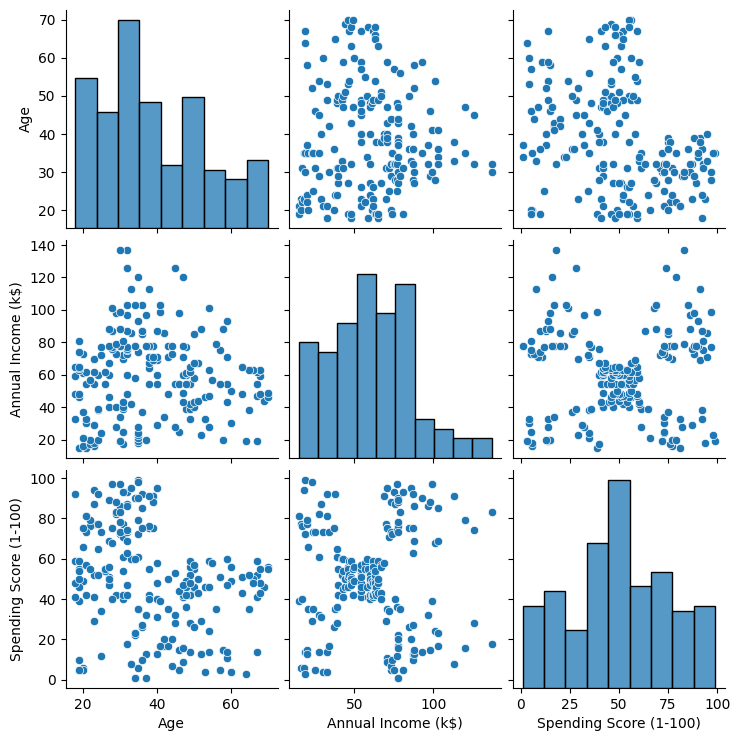

In [3]:
# Parte 2: Carga y análisis exploratorio de los datos
df = pd.read_csv('Mall_Customers.csv')

print(df.head())
print(df.info())
print(df.describe())

# Visualización de la distribución
sns.pairplot(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
plt.show()


**¿Por qué es necesario escalar para K-Means y DBSCAN?**

Ambos algoritmos usan distancias (por ejemplo, distancia euclidiana) para agrupar los datos. Si una variable tiene un rango mucho mayor que otra, dominará la distancia total y, por lo tanto, tendrá más peso en la decisión del algoritmo, aunque no necesariamente sea más importante.

Ejemplo:
* Age: varía entre 18 y 70.

* Annual Income (k$): varía entre 15 y 137.

* Spending Score (1-100): varía entre 1 y 99.


Si no escalas, Annual Income influirá más en el cálculo de distancias simplemente porque sus valores son más grandes.

In [4]:
# Parte 3: Preprocesamiento
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


**¿Qué es K-Means Clustering?**

Es un algoritmo no supervisado que divide los datos en K grupos (clusters) con base en la distancia entre puntos. Cada grupo se forma alrededor de un centroide. El objetivo es minimizar la distancia total entre los puntos y su centroide.

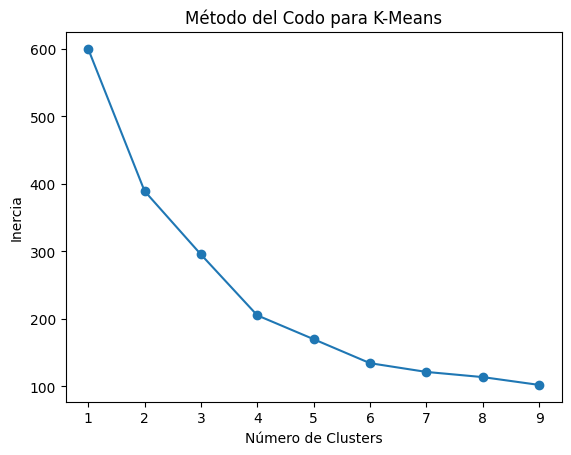

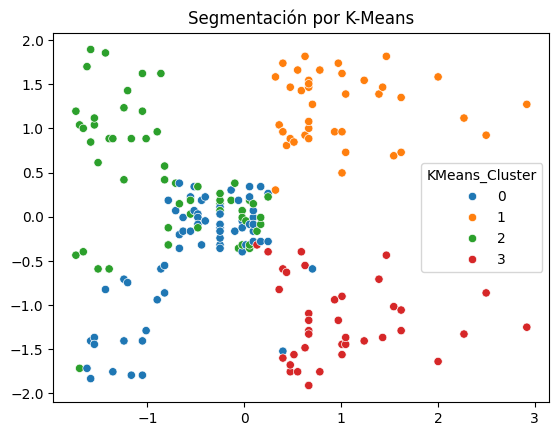

In [5]:
# Parte 4.1: Clustering con K-Means
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Método del Codo
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Número de Clusters') # Numero de grupos
plt.ylabel('Inercia') # la suma de las distancias cuadradas de cada punto a su centroide (cuánto error hay dentro de cada cluster).
plt.title('Método del Codo para K-Means')
plt.show()

# Ajuste del modelo con K óptimo (ej. 4)
kmeans = KMeans(n_clusters=4, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['KMeans_Cluster'], palette='tab10')
plt.title('Segmentación por K-Means')
plt.show()


In [10]:
# Parte 4.1.1: Interpretación de Clustering con K-Means
df.groupby('KMeans_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()


Age  Annual Income (k$)  Spending Score (1-100)
KMeans_Cluster                                                       
0               53.984615           47.707692               39.969231
1               32.875000           86.100000               81.525000
2               25.438596           40.000000               60.298246
3               39.368421           86.500000               19.578947

¿Qué es DBSCAN?

DBSCAN es un algoritmo de clustering basado en densidad. A diferencia de K-Means (que requiere que definas el número de clusters k), DBSCAN:

* Encuentra agrupaciones densas de puntos sin necesidad de saber cuántos clusters hay.

* Identifica automáticamente "ruido" o "outliers", etiquetándolos como -1.

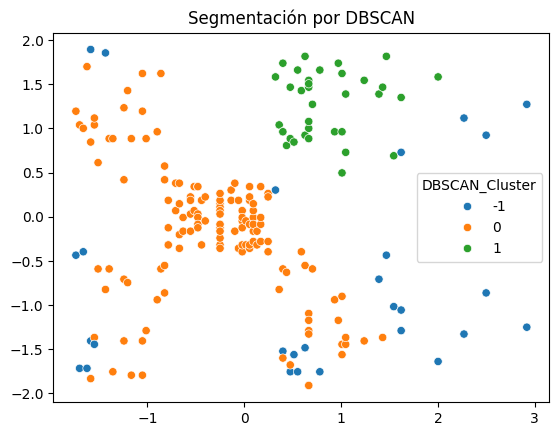

In [6]:
# Parte 4.2: Clustering con DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=5) # eps = radio máximo para considerar que dos puntos están “cerca”./ min_samples =  número mínimo de puntos vecinos necesarios para formar un cluster.
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['DBSCAN_Cluster'], palette='tab10')
plt.title('Segmentación por DBSCAN')
plt.show()


In [13]:
# Parte 4.2.1: Interpretando los Clustering con DBSCAN
df['DBSCAN_Cluster'].value_counts()
df.groupby('DBSCAN_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()





Age  Annual Income (k$)  Spending Score (1-100)
DBSCAN_Cluster                                                       
-1              36.107143           76.857143               33.250000
 0              40.970803           51.613139               45.335766
 1              32.742857           82.542857               82.800000

In [15]:
# Parte 4.2.1: Interpretando los Clustering con DBSCAN sin atípicos
df_no_noise = df[df['DBSCAN_Cluster'] != -1]
df_no_noise.groupby('DBSCAN_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()

Age  Annual Income (k$)  Spending Score (1-100)
DBSCAN_Cluster                                                       
0               40.970803           51.613139               45.335766
1               32.742857           82.542857               82.800000

**¿Qué es PCA?**

PCA (Principal Component Analysis) es una técnica matemática que:

* Reduce el número de variables (dimensiones) de un dataset.

* Conserva la mayor parte de la variabilidad (información) de los datos originales.

* Transforma los datos a componentes principales que son combinaciones lineales de las variables originales.

¿Qué significa reducir de 3 a 2 dimensiones?

Reduces de:

Tres variables originales (Edad, Ingreso, Gasto)

a:

Dos nuevas variables artificiales, llamadas Componentes principales: PC1 y PC2.

Cada una de estas componentes es una combinación lineal de las variables originales. Por ejemplo:



* PC1=0.5⋅Edad+0.7⋅Ingreso+0.5⋅Gasto


* PC2=−0.6⋅Edad+0.4⋅Ingreso+0.7⋅Gasto

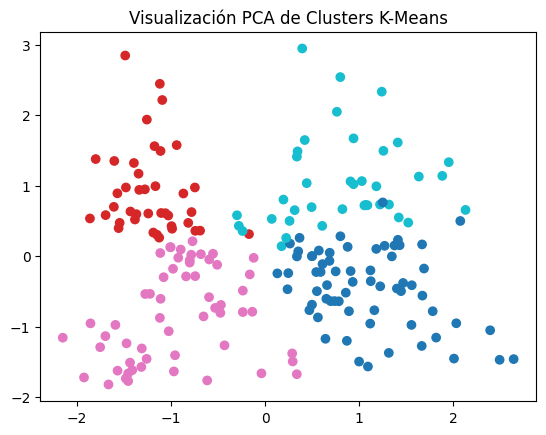

In [7]:
# Parte 5.1: Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['KMeans_Cluster'], cmap='tab10')
plt.title('Visualización PCA de Clusters K-Means')
plt.show()


In [16]:
# Parte 5.1.1: Interpretación de Reducción de dimensionalidad con PCA
df.groupby('KMeans_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()


Age  Annual Income (k$)  Spending Score (1-100)
KMeans_Cluster                                                       
0               53.984615           47.707692               39.969231
1               32.875000           86.100000               81.525000
2               25.438596           40.000000               60.298246
3               39.368421           86.500000               19.578947

In [17]:
# Parte 5.1.2: Interpretación detallada de Reducción de dimensionalidad con PCA
# Mostrar algunos clientes por cluster
for i in range(4):
    print(f"\nCluster {i}")
    display(df[df['KMeans_Cluster'] == i][['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].head())



Cluster 0


Age  Annual Income (k$)  Spending Score (1-100)
6    35                  18                       6
8    64                  19                       3
10   67                  19                      14
12   58                  20                      15
14   37                  20                      13


Cluster 1


Age  Annual Income (k$)  Spending Score (1-100)
122   40                  69                      58
123   39                  69                      91
125   31                  70                      77
127   40                  71                      95
129   38                  71                      75


Cluster 2


Age  Annual Income (k$)  Spending Score (1-100)
0   19                  15                      39
1   21                  15                      81
2   20                  16                       6
3   23                  16                      77
4   31                  17                      40


Cluster 3


Age  Annual Income (k$)  Spending Score (1-100)
112   38                  64                      42
121   38                  67                      40
124   23                  70                      29
126   43                  71                      35
130   47                  71                       9

**¿Qué es t-SNE?**

t-SNE es una técnica de reducción de dimensionalidad no lineal diseñada específicamente para visualización de datos complejos en 2D o 3D.

A diferencia de PCA (que usa combinaciones lineales de variables para preservar la varianza), t-SNE preserva la estructura local de los datos. Es decir:

Los puntos que estaban cerca en el espacio original seguirán cerca en el nuevo espacio 2D.


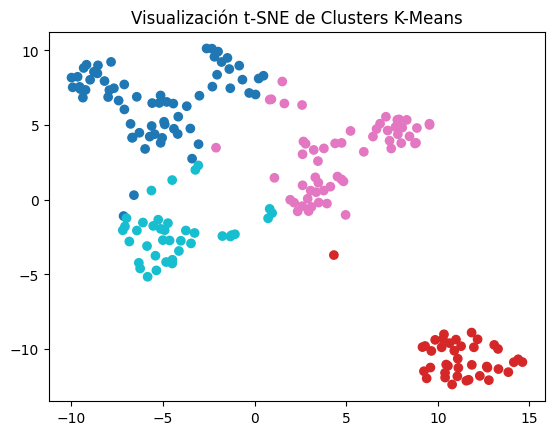

In [8]:
# Parte 5.2: Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42) # cuántos vecinos cercanos considera t-SNE / cuánto se mueven los puntos
X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['KMeans_Cluster'], cmap='tab10')
plt.title('Visualización t-SNE de Clusters K-Means')
plt.show()


In [18]:
# Parte 5.2.1: Interpretación de Reducción de dimensionalidad con t-SNE
df.groupby('KMeans_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()


Age  Annual Income (k$)  Spending Score (1-100)
KMeans_Cluster                                                       
0               53.984615           47.707692               39.969231
1               32.875000           86.100000               81.525000
2               25.438596           40.000000               60.298246
3               39.368421           86.500000               19.578947

In [9]:
# Parte 6: Análisis
print("Clusters únicos KMeans:", df['KMeans_Cluster'].unique())
print("Clusters únicos DBSCAN:", df['DBSCAN_Cluster'].unique())


Clusters únicos KMeans: [2 0 3 1]
Clusters únicos DBSCAN: [-1  0  1]
